In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers

In [ ]:
import os
import re
import csv
import itertools
import json

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import AutoMinorLocator

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk import FreqDist

In [ ]:
import pytorch_pretrained_bert

In [ ]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


# Import BioBERT

In [ ]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_weights && rm -rf /tmp/cookies.txt

In [ ]:
"""!tar -xzf biobert_weights
!ls biobert_v1.1_pubmed/"""

bert_config.json			model.ckpt-1000000.index  vocab.txt
model.ckpt-1000000.data-00000-of-00001	model.ckpt-1000000.meta


In [ ]:
#!transformers-cli convert --model_type bert --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 --config biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

In [ ]:
"""!ls biobert_v1.1_pubmed/
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json
!ls biobert_v1.1_pubmed/"""

In [ ]:
#!ls 

biobert_v1.1_pubmed  biobert_weights  sample_data


# Data

In [ ]:
"""from google.colab import drive
drive._mount('/content/gdrive')"""

Mounted at /content/gdrive


In [ ]:
MAX_LEN=200
BATCH_SIZE=16
#BATCH_SIZE=1
tokenizer = BertTokenizer(vocab_file='biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [ ]:
def tags_list_computer(candidates_list,raw_text_list,thematic_feature):
  """Labels thematic features from there JSON data annotations
  
  
  """
  
  del_features=[]

  for candidate in candidates_list:
    feature_text=[]
    feature_type=re.findall(re.compile('type=\"(.*?)\"'),candidate)[0]
    length=int(re.findall(re.compile('length=\"(.*?)\"'),candidate)[0])
    index=int(re.findall(re.compile('index=(.*?) '),candidate)[0])
    candidate_no=int(re.findall(re.compile('id=\"c(.*?)\"'),candidate)[0])
    
    if feature_type == thematic_feature:
      for i in range(index,index+length):
        del_features.append(raw_text_list[i])  
  return [feat for feat in raw_text_list if feat not in del_features]

In [ ]:
def feature_del(data,thematic_feature):
  """Finds all candidate thematic features by tag from news article
  
  """
  
  raw_text_list=re.findall(re.compile('<token id=\"t\d+\"> (.*?) </token>'),data['tagged_content'])
  candidates_list=re.findall(re.compile('<candidate (.*?)></candidate> '),data['tagged_content'])  
  re_raw_list=tags_list_computer(candidates_list,raw_text_list,thematic_feature)
  raw_doc = ' '.join([str(elem) for elem in re_raw_list])  
  return raw_doc

In [ ]:
corpora = '/content/gdrive/MyDrive/Colab Data/articles'
tagged_data=[]
irrelevant_docs=0
irrelevant_docs_address=[]
df_corpus={'Content':[],'Label':[]}
del_thematic_feature='none' #thematic feature to be ignored either date, disease, location or host

for subdir, dirs, files in os.walk(corpora):
  """Walk through the directory containing PADI-Web JSON News datasets
    Clean the corpus and select relevant and irrelevant documents
    
  """
  for file in files:
    path = os.path.join(subdir, file)
    
    with open(path,'r') as f:
      data=json.load(f)
      if data['candidateLabels']: #not an empty list thus relevant document

        if data['content']:
          content=feature_del(data,del_thematic_feature)
          df_corpus['Content'].append(content.replace('\r', '').replace('\t', '').replace('\n','').replace('<br /> ',''))
          df_corpus['Label'].append('relevant')

      else:#irrelevant document
        if data['content']:
          content=feature_del(data,del_thematic_feature)
          df_corpus['Content'].append(content.replace('\r', '').replace('\t', '').replace('\n','').replace('<br /> ',''))
          df_corpus['Label'].append('irrelevant')

In [ ]:
data=pd.DataFrame(df_corpus)

In [ ]:
data.head()

,Content,Label
0,Instead of creating unnecessary fear and paran...,irrelevant
1,The International Monetary Fund has given Bots...,irrelevant
2,Last updated at : 5:05 AM Malawi Govt optimist...,irrelevant
3,YAMAGUCHI -- An outbreak of highly pathogenic ...,relevant
4,SEOUL South Korea has confirmed a fresh case o...,relevant


In [ ]:
label_encoder=LabelEncoder()
label_encoder.fit(data['Label'])

LabelEncoder()

In [ ]:
X=list(data['Content'])
y=list(label_encoder.transform(data['Label']))

In [ ]:
def tok_with_labels(doc, label):
  """tokenize and keep labels intact"""
  
  tok_doc=tokenizer.tokenize(doc)
  
  return tok_doc, [label]

tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(X, y)]

In [ ]:
tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
"""for char in tok_texts:
    print('WordPiece Tokenizer Preview:\n', char)
    break"""

WordPiece Tokenizer Preview:
 ['Instead', 'of', 'creating', 'unnecessary', 'fear', 'and', 'para', '##no', '##ia', 'over', 'r', '##abi', '##es', 'the', 'authorities', 'should', 'promote', 'proper', 'education', 'on', 'the', 'disease', 'so', 'Malaysian', '##s', 'can', 'better', 'protect', 'themselves', 'and', 'their', 'pets', '.', 'CO', '##MM', '##EN', '##T', 'By', 'Carol', 'N', 'With', 'the', 'announcement', 'of', 'a', 'r', '##abi', '##es', 'outbreak', 'in', 'Malaysia', 'there', 'exists', 'many', 'mi', '##sco', '##nce', '##ption', '##s', 'about', 'the', 'disease', 'and', 'how', 'prevent', '##able', 'and', 'treat', '##able', 'it', 'is', '.', 'All', '##ow', 'me', 'to', 'di', '##sp', '##el', 'some', 'of', 'these', 'myths', 'with', 'referenced', 'sources', '.', 'My', '##th', '1', ':', 'Anyone', 'who', 'gets', 'bitten', 'by', 'a', 'r', '##abi', '##d', 'dog', 'can', 'not', 'be', 'saved', 'and', 'will', 'soon', 'die', 'a', 'terribly', 'painful', 'death', 'It', 'is', 'true', 'that', 'r', '##abi

In [ ]:
# attention masks make explicit reference to which tokens are actual words vs padded words
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [ ]:
split_size=.2

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=split_size)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=split_size)

n_attention_masks = [[float(i != 0.0) for i in ii] for ii in tr_inputs]

tr_masks, test_masks, _, _ = train_test_split(n_attention_masks, tr_inputs,
                                             random_state=2018, test_size=split_size)

tr_inputs, test_inputs, tr_tags, test_tags = train_test_split(tr_inputs, tr_tags,
                                                            random_state=2018, test_size=split_size)

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
test_inputs = torch.tensor(test_inputs)


tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
test_tags = torch.tensor(test_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
test_masks = torch.tensor(test_masks)

In [ ]:
tr_tags.shape

torch.Size([321, 1])

In [ ]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE, drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE, drop_last=True)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE, drop_last=True)

In [ ]:
"""for step,batch in enumerate(train_dataloader):
  print(batch[2].shape)
  #print(batch)
  break"""

torch.Size([16, 1])


# Model

In [ ]:
config = BertConfig.from_json_file('biobert_v1.1_pubmed/config.json')
tmp_d = torch.load('biobert_v1.1_pubmed/pytorch_model.bin', map_location=device)
state_dict = OrderedDict()

for i in list(tmp_d.keys())[:199]:
    x = i
    if i.find('bert') > -1:
        x = '.'.join(i.split('.')[1:])
    state_dict[x] = tmp_d[i]

In [ ]:
state_dict['embeddings.word_embeddings.weight'].shape

torch.Size([28996, 768])

In [ ]:
#bert = BertModel(config)
#bert = bert.load_state_dict(state_dict, strict=False)

In [ ]:
#vocab_len=len(np.unique(labels))+1
vocab_len=2

In [ ]:
class BioBert(nn.Module):

  def __init__(self, vocab_len, config, state_dict):
    super().__init__()
    self.bert = BertModel(config)
    self.bert.load_state_dict(state_dict, strict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.batchnorm=nn.BatchNorm1d(1,affine=False)
    self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    encl = encoded_layer[-1]
    max_pooled, _  = torch.max(encl, 1)
    norm=torch.squeeze(self.batchnorm(torch.unsqueeze(max_pooled,1)),0)
    dropped = self.dropout(norm)
    out = self.output(dropped)
    return out, out.argmax(-1)

In [ ]:
model = BioBert(vocab_len,config,state_dict)
model.to(device)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=1e-5,
    eps=1e-8
)
epochs = 50
max_grad_norm = 1.0

total_steps = len(train_dataloader.dataset) * epochs
warmup_steps = int(epochs * len(train_dataloader.dataset) * 0.1 / BATCH_SIZE) #mine


scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    #num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0.
    batch_no = 1
    for step,batch in enumerate(data_loader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        outputs,y_hat = model(b_input_ids,b_input_mask)
        _,preds = torch.max(outputs,dim=2)

        outputs = outputs.view(-1,outputs.shape[-1])
        b_labels_shaped = b_labels.view(-1)

        loss=loss_fn(outputs,b_labels_shaped)
        correct_predictions += torch.sum(preds == b_labels)
        losses.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        batch_no=batch_no+1

    return correct_predictions.double()/len(data_loader.dataset) , np.mean(losses)

In [ ]:
def model_eval(model,data_loader,loss_fn,device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0.

    original_labels, new_labels = [], []
    
    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
        
            outputs,y_hat = model(b_input_ids,b_input_mask)
        
            _,preds = torch.max(outputs,dim=2)

            outputs = outputs.view(-1,outputs.shape[-1])
            b_labels_shaped = b_labels.view(-1)
            loss = loss_fn(outputs,b_labels_shaped)
            correct_predictions += torch.sum(preds == b_labels)
            losses.append(loss.item())

            label_indices = y_hat.to('cpu').numpy()
            pred_indices = b_labels_shaped.to('cpu').numpy()

            for label_idx,pred_idx in zip(label_indices,pred_indices):
              new_labels.append(label_idx[0])
              original_labels.append(pred_idx)

        print('\nPrecision_Score: ',precision_score(original_labels,new_labels,pos_label=1))
        print('\nRecall_Score: ',recall_score(original_labels,new_labels,pos_label=1))
        print('\nF_Score: ',f1_score(original_labels,new_labels,pos_label=1))
    return correct_predictions/len(data_loader.dataset) , np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
loss_values = []

for epoch in range(epochs):
    
    total_loss = 0
    print(f'======== Epoch {epoch+1}/{epochs} ========')
    train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
    print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
    total_loss += train_loss.item()
    
    avg_train_loss = total_loss / len(train_dataloader.dataset)  
    loss_values.append(avg_train_loss)
    
    val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
    print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

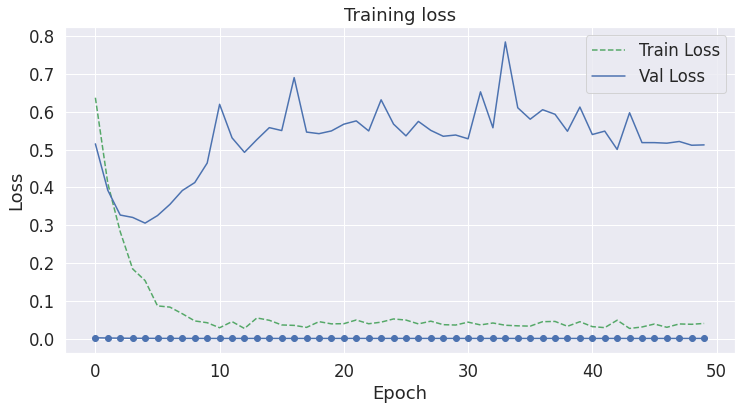

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# learning curve
plt.plot(loss_values, 'b-o')
plt.plot(history['train_loss'],'g--',label='Train Loss')
plt.plot(history['val_loss'],'b',label='Val Loss')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
our_loss=history['train_loss']

In [ ]:
#bert_loss=[0.8866538405418396, 0.9342406988143921, 0.8084975481033325, 0.7875945568084717, 0.8773744702339172, 0.8245067000389099, 0.7760425209999084, 0.7833065390586853, 0.8784903883934021, 0.7521083950996399, 0.7629628777503967, 0.7731646299362183, 0.7511080503463745, 0.7662729620933533, 0.6675549745559692, 0.7358502149581909, 0.6826362609863281, 0.7081995010375977, 0.7610237002372742, 0.600818395614624, 0.6761114001274109, 0.6231296062469482, 0.6330937743186951, 0.6377111673355103, 0.6592248678207397, 0.6200371980667114, 0.6300418972969055, 0.530722975730896, 0.582728385925293, 0.6248407363891602, 0.6432936191558838, 0.5868114233016968, 0.5864548087120056, 0.6127276420593262, 0.5213626623153687, 0.5535983443260193, 0.5250251889228821, 0.5742321610450745, 0.5466144680976868, 0.5156949162483215, 0.5675602555274963, 0.5409212708473206, 0.47458329796791077, 0.5359850525856018, 0.5276238322257996, 0.47876545786857605, 0.4741424322128296, 0.5069094300270081, 0.480573445558548, 0.4598500430583954]

In [ ]:
#our_loss=[0.6374362856149673, 0.41055207028985025, 0.2826789185404778, 0.18426613807678222, 0.15332150217145682, 0.08633588925004006, 0.08309370633214712, 0.06551368031650781, 0.046512353443540634, 0.041783068259246645, 0.02842826563573908, 0.044740932759305, 0.026580724035738967, 0.05442602168186568, 0.04823765884939348, 0.03588703701934719, 0.03473370918436558, 0.029409932198905153, 0.044622573456945244, 0.03876869796549727, 0.039273201106698255, 0.04903118615038693, 0.0390444606760866, 0.043291153057361954, 0.05177566277998267, 0.04882260328176926, 0.0386690808880303, 0.045903233187345904, 0.03661390636953001, 0.03567352056925301, 0.04335395115122083, 0.03596844800194958, 0.04106156575890054, 0.03507911734341178, 0.03355573342341813, 0.0327464080766731, 0.04452912334563734, 0.04522518518206198, 0.03233414188180177, 0.04443824849149678, 0.03148247332464962, 0.028757146170755733, 0.04840938007146178, 0.02664915938039485, 0.0304911126717343, 0.03832555972076079, 0.029668028244486777, 0.038559455154972964, 0.03762170042245998, 0.03991389599686954]

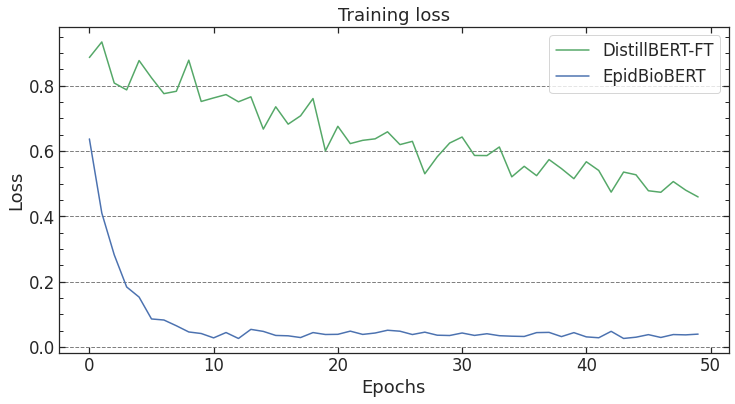

In [ ]:
sns.set_style('ticks',{'ytick.direction': 'in','xtick.direction': 'in','xtick.top': True,'ytick.right': True,'axes.spines.left': True})

fig, ax = plt.subplots()
# learning curve

ax.plot(history['train_loss'],'b',label='EpidBioBERT')


minor_locator = AutoMinorLocator(2)

ax.tick_params(axis='x', which='minor', bottom=False, top=False)
ax.yaxis.set_minor_locator(minor_locator)
ax.yaxis.grid(True,which='major',linestyle='--',color='grey') 
ax.tick_params(axis='x', which='minor', bottom=False)


plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.minorticks_on()
plt.legend()

plt.show()

In [ ]:
#history['train_acc']

# Test

In [ ]:
test_acc,test_loss = model_eval(model,test_dataloader,loss_fn,device)
#test_acc = test_acc
print(f'Test Loss: {test_loss} Test Accuracy: {test_acc}')

Testing on Text

In [ ]:
text="""WHO said on Tuesday that cases of Malaria are increasing. This was very unfrotunate."""
#text="""The Ogun State Government on Monday confirmed that some markets tested positive to the Highly Pathogenic Avian Influenza Virus, known as Bird Flu. The Commissioner for Agriculture, Ronke Sokefun, said this while addressing journalists at her office in Abeokuta, but quickly added that government has put in place measures to contain the spread of the disease."""

In [ ]:
nltk.download('punkt')
sent_text = nltk.sent_tokenize(text)

In [ ]:
tokenized_text = []
for sentence in sent_text:
    tokenized_text.append(nltk.word_tokenize(sentence))

In [ ]:
def tokenize_and_preserve(sentence):
    tokenized_sentence = []
    
    for word in sentence:
        tokenized_word = tokenizer.tokenize(word)   
        tokenized_sentence.extend(tokenized_word)

    return tokenized_sentence

In [ ]:
tok_texts = [
    tokenize_and_preserve(sent) for sent in tokenized_text
]

In [ ]:
#tok_texts

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
input_attentions = [[1]*len(in_id) for in_id in input_ids]

In [ ]:
#input_ids

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids[1])
new_tokens, new_labels = [], []
for token in tokens:
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        
        new_tokens.append(token)

In [ ]:
actual_sentences = []
pred_labels = []
for x,y in zip(input_ids,input_attentions):
    x = torch.tensor(x).cuda()
    y = torch.tensor(y).cuda()
    x = x.view(-1,x.size()[-1])
    y = y.view(-1,y.size()[-1])
    with torch.no_grad():
        _,y_hat = model(x,y)
    label_indices = y_hat.to('cpu').numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
    new_tokens, new_labels = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_labels.append(tag_values[label_idx])
            new_tokens.append(token)
    actual_sentences.append(new_tokens)
    pred_labels.append(new_labels)

In [ ]:
pred_labels

In [ ]:
for token, label in zip(actual_sentences, pred_labels):
    for t,l in zip(token,label):
        print("{}\t{}".format(t, l))

In [ ]:
"""model_save = 'BIONER_classifier.pt'
path = F"models/{model_save}" 
torch.save(model.state_dict(), path)"""